# Using a transfer learning model


Using a different model works in principle the same as the model used in the miniML tutorial. There are a few details to keep in mind, which will be highlighted in the following.

In [1]:
import sys
sys.path.append('/Users/igor/Projects/Data analysis/miniML-release/miniML/core/')
from miniML import MiniTrace, EventDetection
from miniML_plot_functions import miniML_plots

## Running miniML

Generating the trace object works the same as in the miniML tutorial. The only difference here is that we load the data from a .dat file created by HEKA PatchMaster software and need to specify how we named the recording (i.e., the PGF name, here *conti CC*, for continuous current clamp).

In [2]:
filename = '/Users/igor/Projects/Data analysis/miniML-release/miniML/example_data/B_2020-05-14_007.dat'
rectype = 'conti CC'
scaling = 1e3
unit = 'mV'

trace = MiniTrace.from_heka_file(filename=filename,
                                 rectype=rectype,
                                 scaling=scaling,
                                 unit=unit)

Let's plot the loaded data:

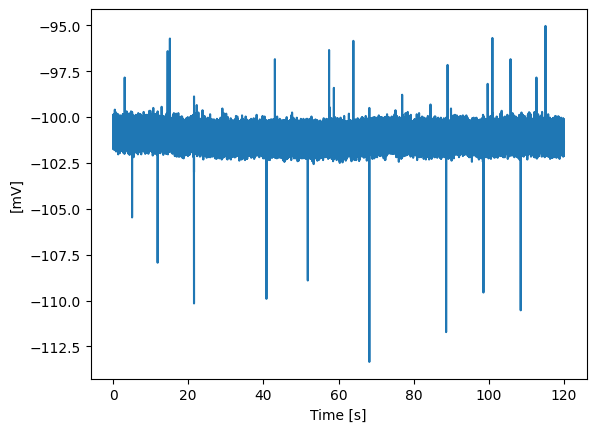

In [3]:
trace.plot_trace()

Creating and initializing a miniML *EventDetection* object also works very similar. Three things have to be considered here:
- Path to the new model has to be specified:
  Either one of our TL models, or the model you trained for your preparation of interest

- Window size (variable *win_size*) has to be specified:
  Our initial model has a window size of 600 points. This was big enough to fully capture one event in cerebellar granule cells. Depending on event kinetics and sampling rate, 600 points may be too much or too little. For example, for our recordings of mEPSPs in the same cell we need 3000 points (see below). The specified window size will also be used to resample the trace for prediction. It is important to use the same window size that the training data has, to prevent a shift in kinetics, which can negatively impact performance. More on this is specified in the documentation for transfer learning.

- You may need to change the two direction parameters:
  "event_direction" specifies the direction of the events in the data and "training_direction" specifies the direction of the events during training. For transfer learning, we typically invert positive events. This improved model performance and made TL easier. This is for example the case for the mEPSP model we use here. In that case, event_direction has to be changed to 'positive', and training direction has to be set to 'negative' as shown below.

In [4]:
model = '/Users/igor/Projects/Data analysis/miniML-release/miniML/models/transfer_learning/GC_mEPSP/lstm_transfer.h5'
win_size = 3000
threshold = 0.5
event_direction = 'positive'
training_direction = 'negative'

detection = EventDetection(data=trace,
                           model_path=model,
                           window_size=win_size,
                           model_threshold=threshold,
                           batch_size=512,
                           event_direction=event_direction,
                           training_direction=training_direction,
                           compile_model=True,
                           verbose=2)

Model loaded from /Users/igor/Projects/Data analysis/miniML-release/miniML/models/transfer_learning/GC_mEPSP/lstm_transfer.h5


In [5]:
detection.detect_events(eval=True, convolve_win=30, resample_to_600=True)

118/118 [==============================] - 3s 21ms/step

Event statistics:
-------------------------
    Number of events: 23
    Average score: 0.969
    Event frequency: 0.1917 Hz
    Mean amplitude: 2.6656 mV
    Median amplitude: 2.5902 mV
    Std amplitude: 1.5294 mV
    CV amplitude: 0.574
    Mean charge: 0.01281 pC
    CV charge: 0.483
    Mean 10-90 risetime: 1.056 ms
    Mean half decay time: 2.943 ms
    Tau decay: 3.624 ms
-------------------------


## Inspect the results

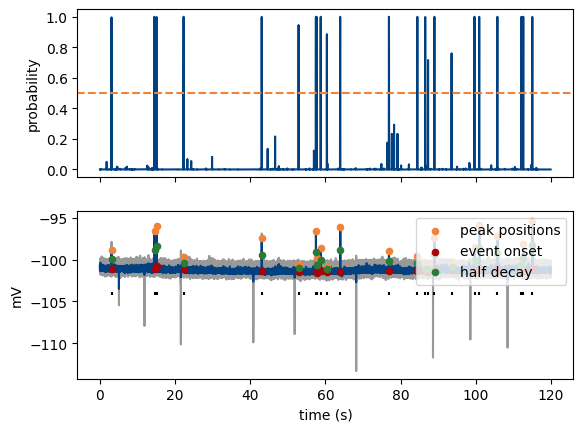

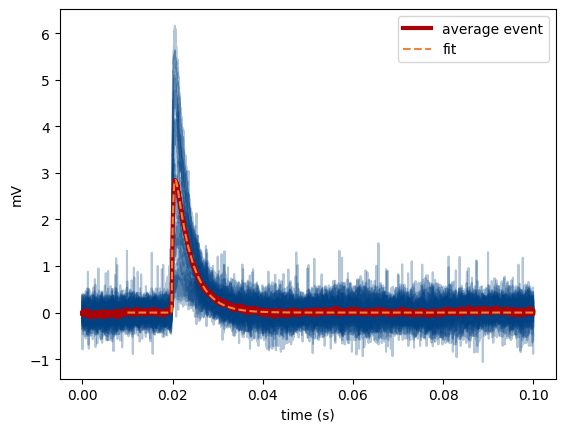

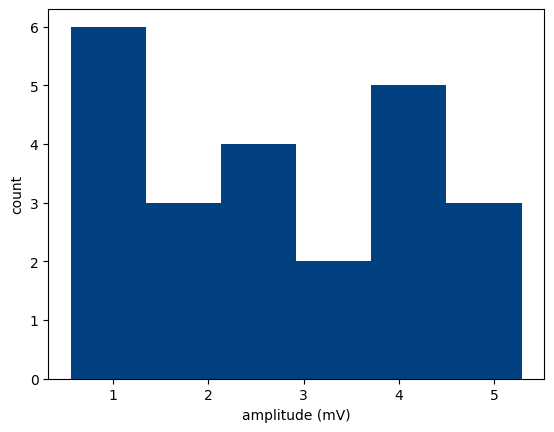

In [6]:
MiniPlots = miniML_plots(data=detection)

MiniPlots.plot_prediction(include_data=True, plot_filtered_prediction=True, plot_filtered_trace=True, plot_event_params=True)
MiniPlots.plot_event_overlay()
MiniPlots.plot_event_histogram(plot='amplitude', cumulative=False)

## Save results to file

To save your results, use the same functions shown in the base tutorial.